In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Mohammed Ghayasuddin - UNB - 3765433

## 1. Import Data


In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf

# text preprocessing
from nltk.tokenize import word_tokenize
import re #REGEX

# plots and metrics
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# preparing input to our model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

# keras layers
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Reshape, LSTM, Dense

Original Dataset

In [3]:
# original dataset from https://www.kaggle.com/datasets/ankitkumar2635/sentiment-and-emotions-of-tweets/
file_path = '/content/drive/MyDrive/Colab Notebooks/sentiment-emotion-labelled_Dell_tweets.csv'
data = pd.read_csv(file_path, encoding='utf-8')
print('Total values in dataset: ', len(data))
data.head(3)

Total values in dataset:  24970


,Unnamed: 0,Datetime,Tweet Id,Text,Username,sentiment,sentiment_score,emotion,emotion_score
0,0,2022-09-30 23:29:15+00:00,1575991191170342912,@Logitech @apple @Google @Microsoft @Dell @Len...,ManjuSreedaran,neutral,0.853283,anticipation,0.587121
1,1,2022-09-30 21:46:35+00:00,1575965354425131008,@MK_habit_addict @official_stier @MortalKombat...,MiKeMcDnet,neutral,0.519470,joy,0.886913
2,2,2022-09-30 21:18:02+00:00,1575958171423752203,"As @CRN celebrates its 40th anniversary, Bob F...",jfollett,positive,0.763791,joy,0.960347


# **Data Pre-processing and Cleaning**

In [4]:
# Only keep columns that show the tweet and its emotion
data = data[['Text', 'emotion']]
data.head(3)

,Text,emotion
0,@Logitech @apple @Google @Microsoft @Dell @Len...,anticipation
1,@MK_habit_addict @official_stier @MortalKombat...,joy
2,"As @CRN celebrates its 40th anniversary, Bob F...",joy


anger           7520
joy             6326
anticipation    5171
disgust         3000
sadness         1328
optimism        1225
fear             366
surprise          34
Name: emotion, dtype: int64


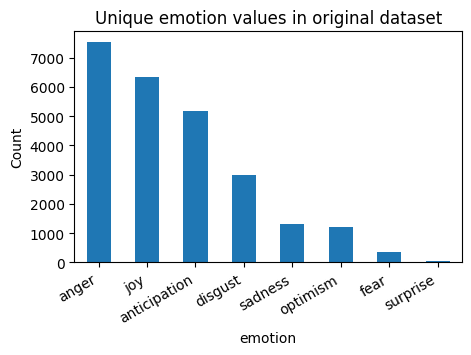

In [5]:
# Count the occurrences of each unique value in emotions in original dataset
value_counts = data['emotion'].value_counts()
print(value_counts)

plt.figure(figsize=(5, 3))
value_counts.plot(kind='bar')
plt.title(f'Unique emotion values in original dataset')
plt.xlabel('emotion')
plt.ylabel('Count')
plt.xticks(rotation=30, ha='right')
plt.show()

## Dataset Manipulation

neutral    9430
anger      7520
joy        6326
sadness    1328
fear        366
Name: emotion, dtype: int64


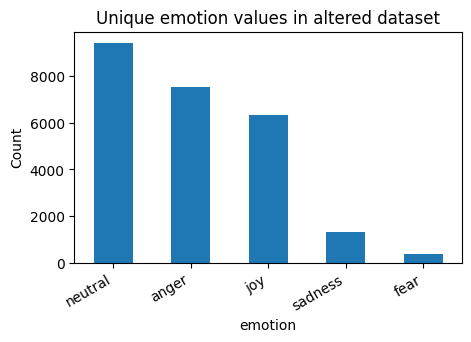

In [6]:
# Map values to 'neutral' if they are not one of our 4 chosen emotions
valid_emotions = ['joy', 'anger', 'fear', 'sadness', 'neutral']
data['emotion'] = data['emotion'].apply(lambda x: x if x in valid_emotions else 'neutral')

data.to_csv('output_file.csv', index=False)

# Count unique occurences after csv modification
value_counts = data['emotion'].value_counts()
print(value_counts)

plt.figure(figsize=(5, 3))
value_counts.plot(kind='bar')
plt.title(f'Unique emotion values in altered dataset')
plt.xlabel('emotion')
plt.ylabel('Count')
plt.xticks(rotation=30, ha='right')
plt.show()

## Train Test Split Dataset 70/30

In [8]:
# Define the features (X) and the target (y)
import pandas as pd
X = data['Text']
y = data['emotion']

# Split the data into training and testing sets (70-30 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Optionally, create new DataFrames for the training and testing sets
data_train = pd.DataFrame({'Text': X_train, 'emotion': y_train})
data_test = pd.DataFrame({'Text': X_test, 'emotion': y_test})

data = pd.concat([data_train, data_test], ignore_index=True)

In [9]:
data.head(3)

,Text,emotion
0,@Dell #XPS13 Plus # Review from @engadget. Th...,neutral
1,Almost ready to start using @ubuntu. Just inst...,joy
2,Trying to work on a slow old desktop or laptop...,neutral


## RegEx + Tokenization

In [10]:
# Function to clean dataset
def clean_text(data):

    # remove #hashtags and @usernames and emojis
    data = re.sub(r"(#[\d\w\.]+)", '', data)
    data = re.sub(r"(@[\d\w\.]+)", '', data)
    data = re.sub(r'[🙂-🙏@#]', '', data)
    data = re.sub(r'\s+', ' ', data).strip()

    # tokenization using nltk
    data = word_tokenize(data)

    return data

In [11]:
import nltk
nltk.download('punkt')
texts = [' '.join(clean_text(text)) for text in data.Text]

texts_train = [' '.join(clean_text(text)) for text in X_train]
texts_test = [' '.join(clean_text(text)) for text in X_test]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [12]:
# Apply regex and tokenization functions
data['Text'] = data['Text'].apply(clean_text)
data.head(3)

,Text,emotion
0,"[Plus, Review, from, The, reviewer, says, ``, ...",neutral
1,"[Almost, ready, to, start, using, Just, instal...",joy
2,"[Trying, to, work, on, a, slow, old, desktop, ...",neutral


In [13]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)

sequence_train = tokenizer.texts_to_sequences(texts_train)
sequence_test = tokenizer.texts_to_sequences(texts_test)

index_of_words = tokenizer.word_index

# Number of unique words + reserved 0 index for padding
vocab_size = len(index_of_words) + 1

print('Number of unique words: {}'.format(len(index_of_words)))

Number of unique words: 34970


## Defining vector space dimension and fixed input size

In [14]:
# Number of labels: joy, anger, fear, sadness, neutral
num_classes = 5

# Number of dimensions for word embedding
embed_num_dims = 300

# Max input length (max number of words)
max_seq_len = 500

class_names = ['joy', 'fear', 'anger', 'sadness', 'neutral']

In [15]:
X_train_pad = pad_sequences(sequence_train, maxlen = max_seq_len )
X_test_pad = pad_sequences(sequence_test, maxlen = max_seq_len )

X_train_pad

array([[    0,     0,     0, ...,     6,     7, 12579],
       [    0,     0,     0, ...,     6,     7, 12580],
       [    0,     0,     0, ...,     6,     7, 12582],
       ...,
       [    0,     0,     0, ...,   245,    18, 28191],
       [    0,     0,     0, ...,    78,    19,   825],
       [    0,     0,     0, ...,     6,     7, 28193]], dtype=int32)

In [16]:
print (X_train.head(3))
print (X_test.head(3))
print (y_train.head(3))
print (y_test.head(3))

12974    @Dell #XPS13 Plus # Review from @engadget.  Th...
10276    Almost ready to start using @ubuntu. Just inst...
22181    Trying to work on a slow old desktop or laptop...
Name: Text, dtype: object
6482     "Using the latest generation @Dell hardware wi...
13625            I need some sponsors for my channel @Dell
21043    @lilzozu @bravadogaming @Alienware @intel @Int...
Name: Text, dtype: object
12974    neutral
10276        joy
22181    neutral
Name: emotion, dtype: object
6482         joy
13625    neutral
21043    neutral
Name: emotion, dtype: object


## Encode and Categorise labels (Emotions)

In [17]:
def encode_labels(labels, encoding):
    encoded_labels = [encoding[label] for label in labels]
    return encoded_labels

# Define the encoding dictionary
encoding = {
    'joy': 0,
    'fear': 1,
    'anger': 2,
    'sadness': 3,
    'neutral': 4
}

# Use the function to encode the labels
y_train = encode_labels(y_train, encoding)
y_test = encode_labels(y_test, encoding)

print(y_train)

[4, 0, 4, 2, 0, 2, 4, 4, 4, 4, 0, 2, 4, 4, 4, 4, 4, 0, 4, 0, 0, 0, 0, 4, 4, 2, 4, 2, 2, 0, 4, 2, 4, 4, 2, 2, 4, 0, 2, 4, 4, 4, 0, 0, 0, 0, 4, 2, 0, 0, 0, 3, 4, 2, 0, 4, 2, 2, 2, 4, 0, 4, 4, 2, 4, 2, 2, 0, 0, 2, 3, 0, 0, 0, 2, 2, 4, 2, 2, 4, 2, 4, 2, 4, 4, 0, 2, 0, 4, 4, 4, 4, 3, 0, 4, 3, 4, 4, 0, 3, 4, 3, 1, 0, 2, 2, 0, 4, 2, 3, 4, 2, 2, 0, 4, 4, 3, 0, 0, 0, 0, 2, 4, 0, 2, 2, 4, 2, 3, 3, 4, 0, 0, 2, 0, 4, 0, 0, 0, 0, 2, 0, 2, 4, 4, 2, 4, 0, 4, 0, 3, 4, 0, 0, 3, 4, 2, 4, 2, 0, 0, 4, 4, 0, 0, 2, 4, 1, 2, 0, 0, 4, 4, 0, 4, 0, 0, 1, 4, 2, 3, 2, 0, 4, 0, 0, 4, 4, 4, 2, 0, 2, 1, 4, 2, 2, 4, 4, 4, 0, 0, 3, 3, 2, 4, 2, 3, 4, 4, 4, 4, 4, 4, 2, 0, 3, 4, 2, 4, 3, 4, 4, 4, 3, 4, 4, 2, 2, 4, 0, 4, 4, 4, 3, 0, 2, 4, 0, 4, 0, 2, 4, 2, 2, 3, 2, 0, 0, 4, 2, 4, 2, 2, 3, 4, 2, 4, 4, 3, 4, 0, 4, 0, 2, 4, 4, 4, 0, 4, 4, 4, 2, 0, 0, 4, 2, 2, 0, 4, 4, 0, 0, 2, 2, 0, 4, 4, 2, 4, 4, 2, 4, 2, 0, 4, 4, 4, 4, 2, 3, 2, 4, 4, 2, 0, 4, 2, 3, 0, 4, 3, 2, 0, 2, 0, 0, 0, 0, 0, 3, 4, 0, 4, 3, 0, 4, 4, 0, 4, 4, 2, 2, 2, 

In [18]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

y_train

array([[0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.]], dtype=float32)

## Import pretrained word vectors

In [19]:
def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word]
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]
    return embedding_matrix

In [20]:
import urllib.request
import zipfile
import os

fname = 'embeddings/wiki-news-300d-1M.vec'

if not os.path.isfile(fname):
    print('Downloading word vectors...')
    urllib.request.urlretrieve('https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip',
                              'wiki-news-300d-1M.vec.zip')
    print('Unzipping...')
    with zipfile.ZipFile('wiki-news-300d-1M.vec.zip', 'r') as zip_ref:
        zip_ref.extractall('embeddings')
    print('done.')

    os.remove('wiki-news-300d-1M.vec.zip')

Unzipping...
done.


In [21]:
embedd_matrix = create_embedding_matrix(fname, index_of_words, embed_num_dims)
embedd_matrix.shape

(34971, 300)

In [22]:
# Inspect unseen words
new_words = 0

for word in index_of_words:
    entry = embedd_matrix[index_of_words[word]]
    if all(v == 0 for v in entry):
        new_words = new_words + 1

print('Words found in wiki vocab: ' + str(len(index_of_words) - new_words))
print('New words found: ' + str(new_words))

Words found in wiki vocab: 18956
New words found: 16014


In [23]:
# Embedding layer
embedd_layer = Embedding(vocab_size,
                         embed_num_dims,
                         input_length = max_seq_len,
                         weights = [embedd_matrix],
                         trainable=False)

# **CNN Model**

In [24]:
kernel_size = 3
filters = 256

model = Sequential()
model.add(embedd_layer)
model.add(Conv1D(filters, kernel_size, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(256, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

In [25]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 300)          10491300  
                                                                 
 conv1d (Conv1D)             (None, 498, 256)          230656    
                                                                 
 global_max_pooling1d (Glob  (None, 256)               0         
 alMaxPooling1D)                                                 
                                                                 
 dense (Dense)               (None, 256)               65792     
                                                                 
 dense_1 (Dense)             (None, 5)                 1285      
                                                                 
Total params: 10789033 (41.16 MB)
Trainable params: 297733 (1.14 MB)
Non-trainable params: 10491300 (40.02 MB)
___________

## Train CNN Model

In [26]:
batch_size = 256
epochs = 50

hist = model.fit(X_train_pad, y_train,
                 batch_size=batch_size,
                 epochs=epochs,
                 validation_data=(X_test_pad,y_test))

Epoch 1/50
69/69 [==============================] - 9s 61ms/step - loss: 1.0366 - accuracy: 0.5789 - val_loss: 0.7952 - val_accuracy: 0.6992
Epoch 2/50
69/69 [==============================] - 3s 48ms/step - loss: 0.7094 - accuracy: 0.7317 - val_loss: 0.7050 - val_accuracy: 0.7397
Epoch 3/50
69/69 [==============================] - 3s 48ms/step - loss: 0.5709 - accuracy: 0.7920 - val_loss: 0.6875 - val_accuracy: 0.7392
Epoch 4/50
69/69 [==============================] - 3s 50ms/step - loss: 0.4444 - accuracy: 0.8450 - val_loss: 0.6621 - val_accuracy: 0.7480
Epoch 5/50
69/69 [==============================] - 4s 51ms/step - loss: 0.3284 - accuracy: 0.8964 - val_loss: 0.6569 - val_accuracy: 0.7434
Epoch 6/50
69/69 [==============================] - 4s 53ms/step - loss: 0.2301 - accuracy: 0.9354 - val_loss: 0.6984 - val_accuracy: 0.7517
Epoch 7/50
69/69 [==============================] - 4s 54ms/step - loss: 0.1496 - accuracy: 0.9648 - val_loss: 0.7176 - val_accuracy: 0.7477
Epoch 8/50
69

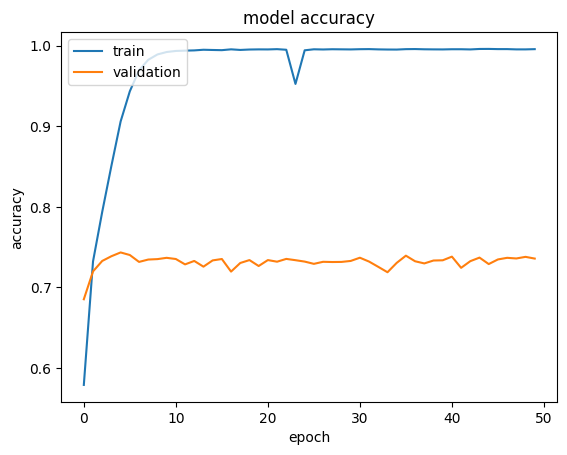

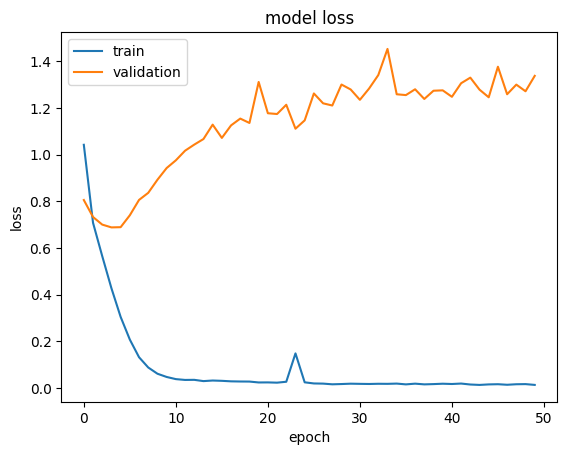

In [ ]:
# Accuracy plot of CNN
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Loss plot of CNN
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
predictions = model.predict(X_test_pad)
predictions = np.argmax(predictions, axis=1)
predictions = [class_names[pred] for pred in predictions]

235/235 [==============================] - 1s 5ms/step


## Accuracy and Loss of CNN

In [ ]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    '''
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    '''
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()

    # Set size
    fig.set_size_inches(12.5, 7.5)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.grid(False)

    # Show all ticks and label them with the respective list entries
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

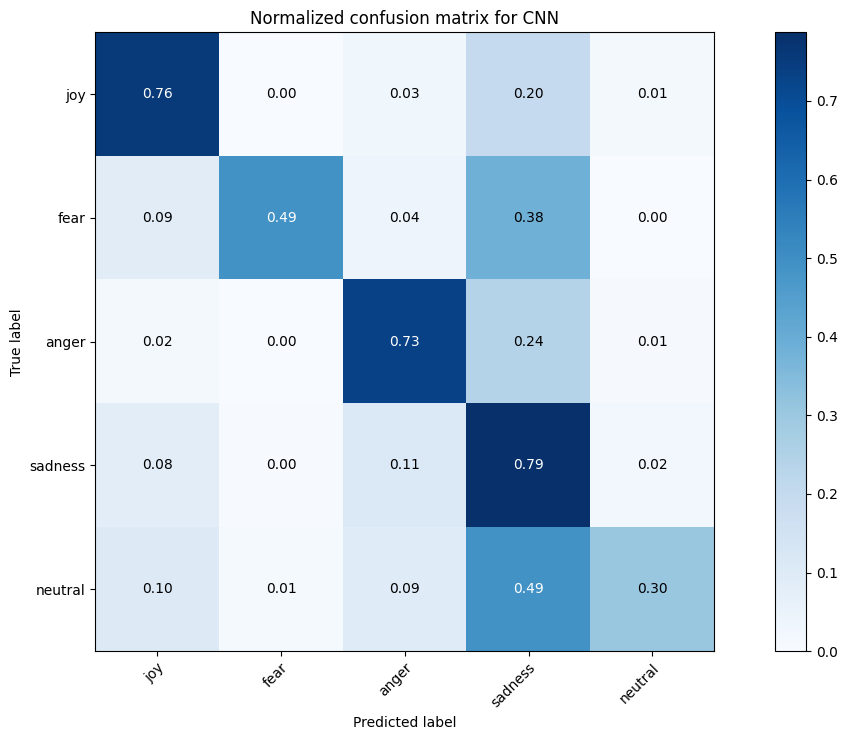

In [ ]:
# Plot normalized confusion matrix
plot_confusion_matrix(data_test.emotion, predictions, classes=class_names, normalize=True, title='Normalized confusion matrix for CNN')
plt.show()

In [ ]:
encoding = {
    0: 'joy',
    1: 'fear',
    2: 'anger',
    3: 'sadness',
    4: 'neutral'
}

classification_report_model = classification_report(data_test.emotion, predictions, target_names=encoding.values())
print(classification_report_model)
print("Accuracy of CNN model: {:.2f}%".format(accuracy_score(data_test.emotion, predictions) * 100))
print("\nF1 Score of CNN: {:.2f}".format(f1_score(data_test.emotion, predictions, average='micro') * 100))

              precision    recall  f1-score   support

         joy       0.85      0.76      0.80      2232
        fear       0.73      0.49      0.59       104
       anger       0.78      0.73      0.75      1938
     sadness       0.66      0.79      0.72      2835
     neutral       0.53      0.30      0.39       382

    accuracy                           0.74      7491
   macro avg       0.71      0.61      0.65      7491
weighted avg       0.74      0.74      0.73      7491

Accuracy of CNN model: 73.58%

F1 Score of CNN: 73.58


In [ ]:
# Clear applied layers and model to test new model
from keras.backend import clear_session
clear_session()

# **LSTM Model**

## Train LSTM Model

In [ ]:
from tensorflow import keras
from keras.layers import Embedding, LSTM, Dense

In [ ]:
kernel_size = 3
filters = 256

model = Sequential()
model.add(embedd_layer)
model.add(LSTM(256))
model.add(Dense(5, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

In [ ]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 300)          10491300  
                                                                 
 lstm (LSTM)                 (None, 256)               570368    
                                                                 
 dense (Dense)               (None, 5)                 1285      
                                                                 
 dense_1 (Dense)             (None, 5)                 30        
                                                                 
Total params: 11062983 (42.20 MB)
Trainable params: 571683 (2.18 MB)
Non-trainable params: 10491300 (40.02 MB)
_________________________________________________________________


In [ ]:
batch_size = 256
epochs = 50

hist = model.fit(X_train_pad, y_train,
                 batch_size=batch_size,
                 epochs=epochs,
                 validation_data=(X_test_pad,y_test))

Epoch 1/50
69/69 [==============================] - 18s 207ms/step - loss: 1.2106 - accuracy: 0.4678 - val_loss: 1.0818 - val_accuracy: 0.5930
Epoch 2/50
69/69 [==============================] - 14s 205ms/step - loss: 1.0369 - accuracy: 0.6117 - val_loss: 1.0070 - val_accuracy: 0.6477
Epoch 3/50
69/69 [==============================] - 14s 208ms/step - loss: 0.9258 - accuracy: 0.6662 - val_loss: 0.8913 - val_accuracy: 0.6846
Epoch 4/50
69/69 [==============================] - 14s 203ms/step - loss: 0.8412 - accuracy: 0.7006 - val_loss: 0.8508 - val_accuracy: 0.6887
Epoch 5/50
69/69 [==============================] - 14s 200ms/step - loss: 0.7964 - accuracy: 0.7105 - val_loss: 0.8148 - val_accuracy: 0.7008
Epoch 6/50
69/69 [==============================] - 14s 199ms/step - loss: 0.7533 - accuracy: 0.7193 - val_loss: 0.8019 - val_accuracy: 0.6926
Epoch 7/50
69/69 [==============================] - 14s 201ms/step - loss: 0.7148 - accuracy: 0.7313 - val_loss: 0.7538 - val_accuracy: 0.7134

## Accuracy and Loss of LSTM


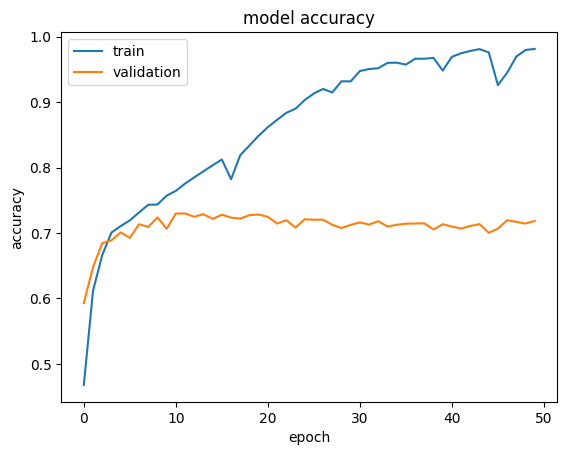

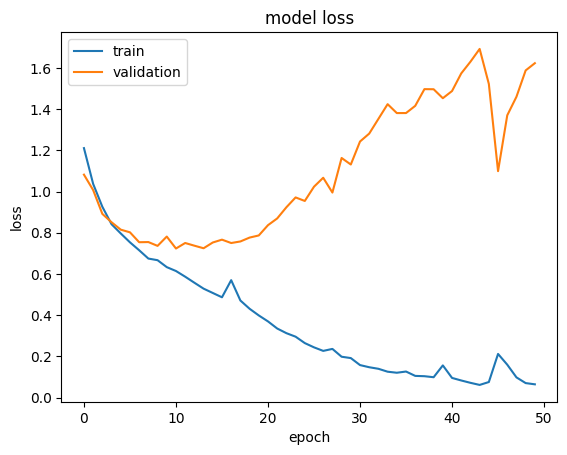

In [ ]:
# Accuracy plot for LSTM
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Loss plot for LSTM
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
predictions = model.predict(X_test_pad)
predictions = np.argmax(predictions, axis=1)
predictions = [class_names[pred] for pred in predictions]

235/235 [==============================] - 3s 13ms/step


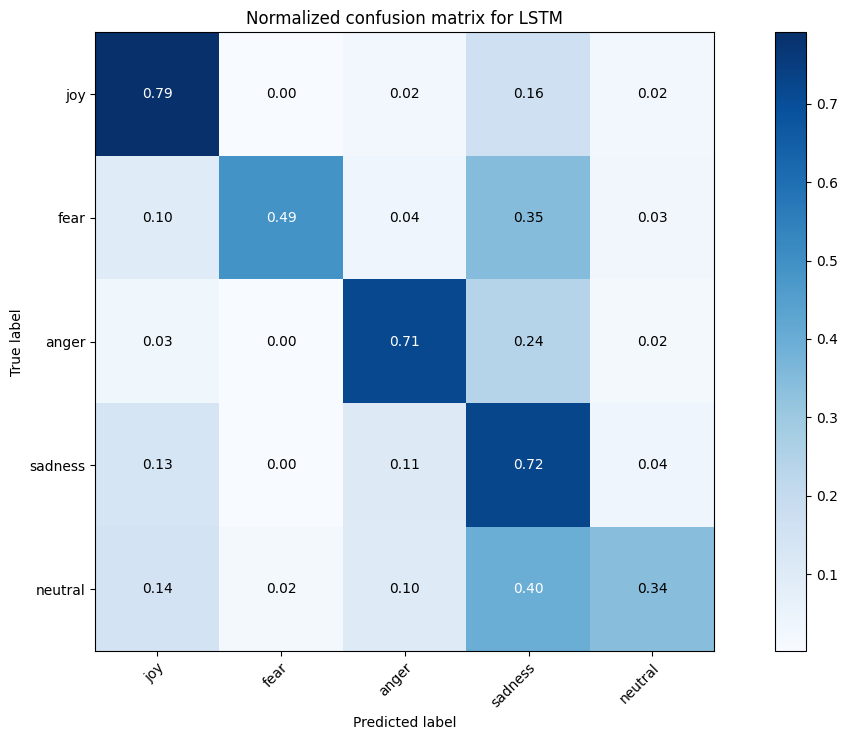

In [ ]:
# Plot normalized confusion matrix
plot_confusion_matrix(data_test.emotion, predictions, classes=class_names, normalize=True, title='Normalized confusion matrix for LSTM')
plt.show()

In [ ]:
encoding = {
    0: 'joy',
    1: 'fear',
    2: 'anger',
    3: 'sadness',
    4: 'neutral'
}

classification_report_model = classification_report(data_test.emotion, predictions, target_names=encoding.values())
print(classification_report_model)
print("Test accuracy of LSTM model: {:.2f}%".format(accuracy_score(data_test.emotion, predictions) * 100))
print("\nF1 Score of LSTM: {:.2f}".format(f1_score(data_test.emotion, predictions, average='micro') * 100))

              precision    recall  f1-score   support

         joy       0.78      0.79      0.79      2232
        fear       0.65      0.49      0.56       104
       anger       0.78      0.71      0.75      1938
     sadness       0.67      0.72      0.70      2835
     neutral       0.42      0.34      0.37       382

    accuracy                           0.72      7491
   macro avg       0.66      0.61      0.63      7491
weighted avg       0.72      0.72      0.72      7491

Test accuracy of LSTM model: 71.83%

F1 Score of LSTM: 71.83


In [ ]:
# Clear applied layers and model to test new model
from keras.backend import clear_session
clear_session()

# **CNN + LSTM Model**

## Train CNN + LSTM Model

In [ ]:
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Reshape, LSTM, Dense

In [ ]:
kernel_size = 3
filters = 256

model = Sequential()
model.add(embedd_layer)
model.add(Conv1D(filters, kernel_size, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Reshape((1, 256)))
model.add(LSTM(256)) # pass data through LSTM layer after Conv1D layer
model.add(Dense(256, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

In [ ]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 300)          10491300  
                                                                 
 conv1d (Conv1D)             (None, 498, 256)          230656    
                                                                 
 global_max_pooling1d (Glob  (None, 256)               0         
 alMaxPooling1D)                                                 
                                                                 
 reshape (Reshape)           (None, 1, 256)            0         
                                                                 
 lstm (LSTM)                 (None, 256)               525312    
                                                                 
 dense (Dense)               (None, 256)               65792     
                                                        

In [ ]:
batch_size = 256
epochs = 50

hist = model.fit(X_train_pad, y_train,
                 batch_size=batch_size,
                 epochs=epochs,
                 validation_data=(X_test_pad,y_test))

Epoch 1/50
69/69 [==============================] - 9s 88ms/step - loss: 1.0977 - accuracy: 0.5302 - val_loss: 0.8412 - val_accuracy: 0.6717
Epoch 2/50
69/69 [==============================] - 5s 79ms/step - loss: 0.7315 - accuracy: 0.7269 - val_loss: 0.7413 - val_accuracy: 0.7206
Epoch 3/50
69/69 [==============================] - 5s 69ms/step - loss: 0.5905 - accuracy: 0.7860 - val_loss: 0.7368 - val_accuracy: 0.7281
Epoch 4/50
69/69 [==============================] - 5s 79ms/step - loss: 0.4223 - accuracy: 0.8558 - val_loss: 0.7685 - val_accuracy: 0.7230
Epoch 5/50
69/69 [==============================] - 5s 79ms/step - loss: 0.2793 - accuracy: 0.9078 - val_loss: 0.8855 - val_accuracy: 0.7278
Epoch 6/50
69/69 [==============================] - 5s 69ms/step - loss: 0.1635 - accuracy: 0.9502 - val_loss: 1.0478 - val_accuracy: 0.7141
Epoch 7/50
69/69 [==============================] - 5s 71ms/step - loss: 0.1232 - accuracy: 0.9620 - val_loss: 1.0955 - val_accuracy: 0.7234
Epoch 8/50
69

## Accuracy and Loss of CNN + LSTM

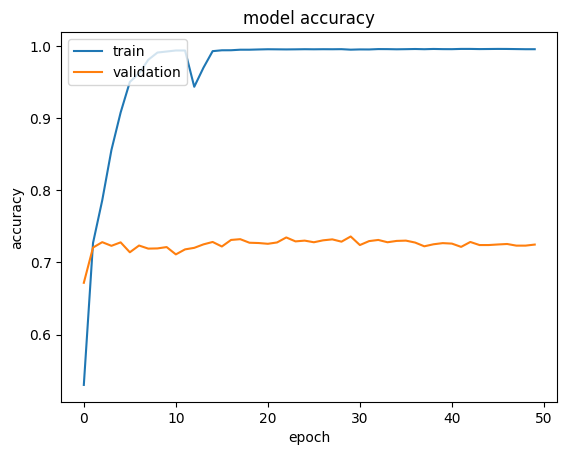

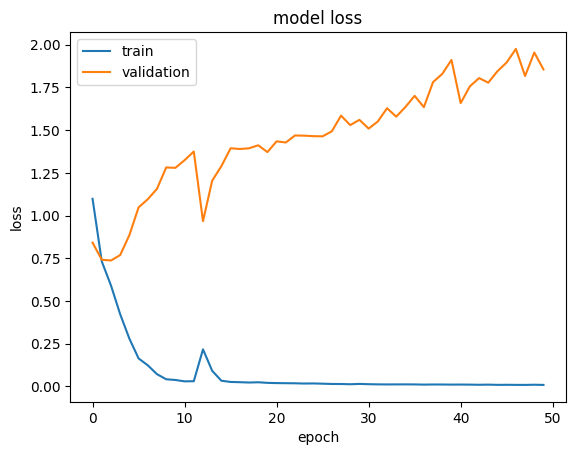

In [ ]:
# Accuracy plot for CNN+LSTM
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Loss plot for CNN+LSTM
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
predictions = model.predict(X_test_pad)
predictions = np.argmax(predictions, axis=1)
predictions = [class_names[pred] for pred in predictions]

235/235 [==============================] - 1s 4ms/step


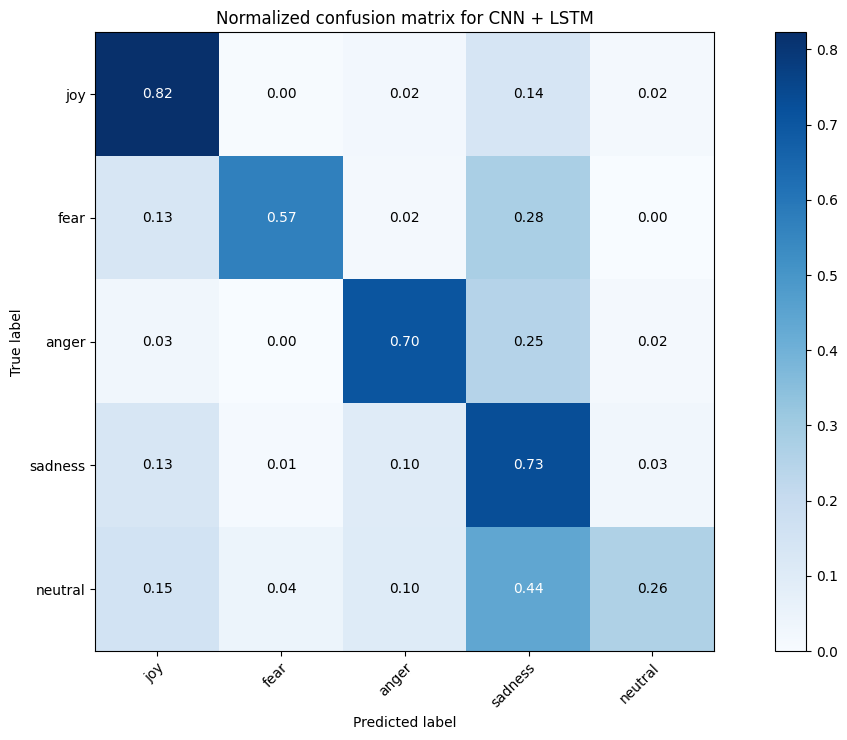

In [ ]:
# Plot normalized confusion matrix
plot_confusion_matrix(data_test.emotion, predictions, classes=class_names, normalize=True, title='Normalized confusion matrix for CNN + LSTM')
plt.show()

In [ ]:
encoding = {
    0: 'joy',
    1: 'fear',
    2: 'anger',
    3: 'sadness',
    4: 'neutral'
}

classification_report_model = classification_report(data_test.emotion, predictions, target_names=encoding.values())
print(classification_report_model)
print("Test accuracy of CNN+LSTM model: {:.2f}%".format(accuracy_score(data_test.emotion, predictions) * 100))
print("\nF1 Score of CNN+LSTM: {:.2f}".format(f1_score(data_test.emotion, predictions, average='micro') * 100))

              precision    recall  f1-score   support

         joy       0.79      0.82      0.80      2232
        fear       0.48      0.57      0.52       104
       anger       0.79      0.70      0.74      1938
     sadness       0.68      0.73      0.70      2835
     neutral       0.41      0.26      0.32       382

    accuracy                           0.72      7491
   macro avg       0.63      0.62      0.62      7491
weighted avg       0.72      0.72      0.72      7491

Test accuracy of CNN+LSTM model: 72.47%

F1 Score of CNN+LSTM: 72.47


# Let's try other inputs:

In [ ]:
import time

message = ['I really enjoyed this ML course.']

seq = tokenizer.texts_to_sequences(message)
padded = pad_sequences(seq, maxlen=max_seq_len)

start_time = time.time()
pred = model.predict(padded)

print('Message: ' + str(message))
print('predicted: {} ({:.2f} seconds)'.format(class_names[np.argmax(pred)], (time.time() - start_time)))

1/1 [==============================] - 0s 57ms/step
Message: ['I really enjoyed this ML course.']
predicted: joy (0.11 seconds)


In [ ]:
# Clear applied layers and model to test new model
from keras.backend import clear_session
clear_session()

# **SVM**

In [ ]:
# Applying an SVM model for comparison purposes

import random
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.feature_selection import SelectKBest, chi2

nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

tokenized_tweets = [' '.join(word_tokenize(str(tweet).lower())) for tweet in data['Text']]
emotions = data['emotion']

tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words=stopwords.words('english'), ngram_range=(1, 2))
X = tfidf_vectorizer.fit_transform(tokenized_tweets)

chi2_selector = SelectKBest(chi2, k=2000)
X = chi2_selector.fit_transform(X, emotions)

X_train, X_test, y_train, y_test = train_test_split(X, emotions, test_size=0.3, random_state=42)

classifier = SVC(kernel='linear', C=1.0)
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)

classification_report_model = classification_report(y_test, y_pred, target_names=encoding.values())
print(classification_report_model)
accuracy = accuracy_score(y_test, y_pred)
print("Test accuracy of SVM model: {:.2f}%".format(accuracy * 100))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


              precision    recall  f1-score   support

         joy       0.80      0.76      0.78      2221
        fear       0.97      0.30      0.45       115
       anger       0.84      0.58      0.69      1901
     sadness       0.61      0.85      0.71      2841
     neutral       0.72      0.14      0.24       413

    accuracy                           0.71      7491
   macro avg       0.79      0.52      0.57      7491
weighted avg       0.74      0.71      0.69      7491

Test accuracy of SVM model: 70.52%


In [ ]:
#Testing using SVM
new_tweet = "I am the best"
new_tweet_vectorized = tfidf_vectorizer.transform([new_tweet])
new_tweet_features = chi2_selector.transform(new_tweet_vectorized)
emotion = classifier.predict(new_tweet_features)
print("Emotion for the new tweet:", emotion[0])

Emotion for the new tweet: joy


In [ ]:
# Clear applied layers and model to test new model
from keras.backend import clear_session
clear_session()

# **Naive Bayes Classifier**

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from nltk.classify import NaiveBayesClassifier

classifier = MultinomialNB()
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

classification_report_model = classification_report(y_test, y_pred, target_names=encoding.values())
print(classification_report_model)
accuracy = accuracy_score(y_test, y_pred)
print("Test accuracy of Naive Bayes model: {:.2f}%".format(accuracy * 100))

              precision    recall  f1-score   support

         joy       0.71      0.81      0.76      2221
        fear       1.00      0.12      0.22       115
       anger       0.83      0.57      0.68      1901
     sadness       0.61      0.78      0.68      2841
     neutral       0.75      0.03      0.06       413

    accuracy                           0.68      7491
   macro avg       0.78      0.46      0.48      7491
weighted avg       0.71      0.68      0.66      7491

Test accuracy of Naive Bayes model: 68.38%


In [ ]:
#Testing using NB
new_tweet = "I'm feeling so happy today."
new_tweet_vectorized = tfidf_vectorizer.transform([new_tweet])
new_tweet_features = chi2_selector.transform(new_tweet_vectorized)
emotion = classifier.predict(new_tweet_features)
print("Emotion for the new tweet:", emotion[0])

Emotion for the new tweet: joy
